In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans


In [3]:
df = pd.read_csv('/content/Creditcard_data.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Class'].value_counts()


,count
Class,
0,763
1,9


In [5]:
X = df.drop('Class', axis=1)
y = df['Class']


In [6]:
ros = RandomOverSampler(random_state=42)
X_bal, y_bal = ros.fit_resample(X, y)

balanced_df = pd.concat([X_bal, y_bal], axis=1)
balanced_df['Class'].value_counts()


,count
Class,
0,763
1,763


In [7]:
Z = 1.96
p = 0.5
E = 0.05

n = int((Z**2 * p * (1 - p)) / (E**2))
n


384

In [8]:
def simple_random_sampling(df, n):
    return df.sample(n=n, random_state=42)

def systematic_sampling(df, n):
    step = len(df) // n
    indices = np.arange(0, len(df), step)
    return df.iloc[indices[:n]]

def stratified_sampling(df, n):
    return df.groupby('Class', group_keys=False).apply(
        lambda x: x.sample(int(n/2), random_state=42)
    )

def cluster_sampling(df, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(df.drop('Class', axis=1))
    chosen_cluster = np.random.choice(df['cluster'].unique())
    return df[df['cluster'] == chosen_cluster].drop('cluster', axis=1)

def bootstrap_sampling(df, n):
    return df.sample(n=n, replace=True, random_state=42)



In [9]:
samples = {
    "Simple Random": simple_random_sampling(balanced_df, n),
    "Systematic": systematic_sampling(balanced_df, n),
    "Stratified": stratified_sampling(balanced_df, n),
    "Cluster": cluster_sampling(balanced_df),
    "Bootstrap": bootstrap_sampling(balanced_df, n)
}


/tmp/ipython-input-1486757594.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Class', group_keys=False).apply(


In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}


In [13]:
results = pd.DataFrame(index=models.keys(), columns=samples.keys())

for s_name, sample_df in samples.items():
    X_s = sample_df.drop('Class', axis=1)
    y_s = sample_df['Class']

    X_train, X_test, y_train, y_test = train_test_split(
        X_s, y_s, test_size=0.3, random_state=42
    )

    for m_name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results.loc[m_name, s_name] = acc


In [14]:
results


,Simple Random,Systematic,Stratified,Cluster,Bootstrap
Logistic Regression,0.844828,0.87931,0.913793,1.0,0.956897
Decision Tree,0.982759,0.974138,0.965517,1.0,0.991379
Random Forest,1.0,0.991379,0.991379,1.0,1.0
SVM,0.689655,0.715517,0.715517,0.701987,0.741379
KNN,0.948276,0.913793,0.87931,0.993377,0.931034


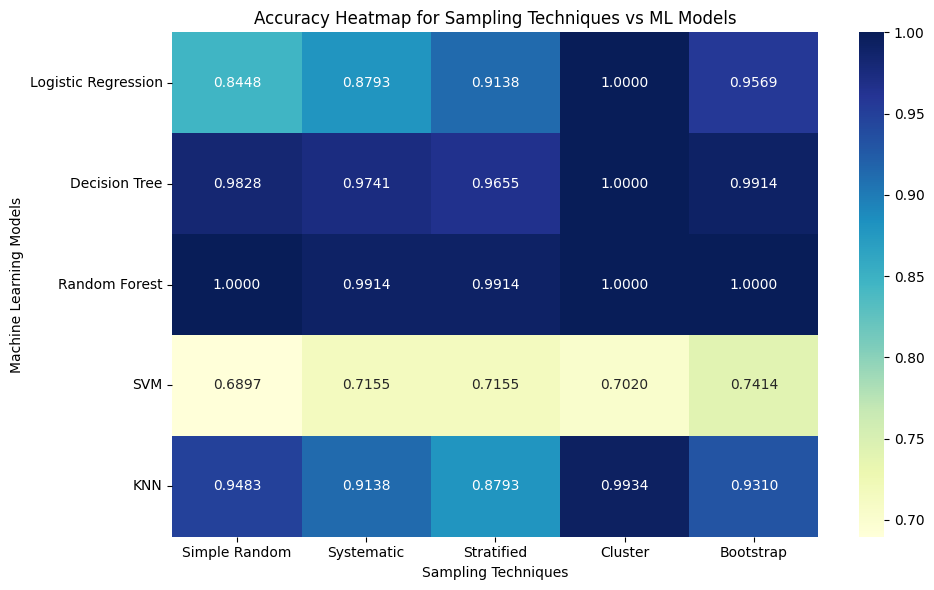

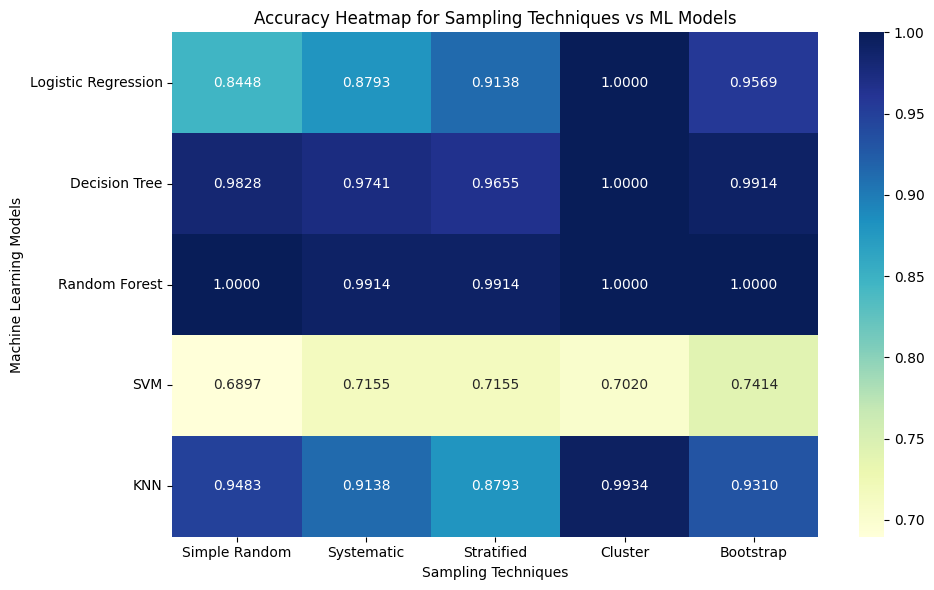

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(
    results.astype(float),
    annot=True,
    cmap="YlGnBu",
    fmt=".4f"
)

plt.title("Accuracy Heatmap for Sampling Techniques vs ML Models")
plt.xlabel("Sampling Techniques")
plt.ylabel("Machine Learning Models")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.heatmap(
    results.astype(float),
    annot=True,
    cmap="YlGnBu",
    fmt=".4f"
)
plt.title("Accuracy Heatmap for Sampling Techniques vs ML Models")
plt.xlabel("Sampling Techniques")
plt.ylabel("Machine Learning Models")
plt.tight_layout()
plt.savefig("sampling_accuracy_heatmap.png")
plt.show()
